Flight Price Prediction Project

Anyone who has booked a flight ticket knows how unexpectedly the prices vary. The cheapest available ticket on a given flight gets more and less expensive over time. In this project we have first scraped data from "yatra.com" using Selenium and then build a regression model predicting prices.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
import pickle

import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:
df=pd.read_csv(r"FlightData1.csv", parse_dates=["Date"])
df.head()

,Unnamed: 0,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price
0,0,Go First,19 May,02:40,04:55,New Delhi,Mumbai,Non Stop,2h 15m,"2,410"
1,1,Air India,19 May,07:00,09:05,New Delhi,Mumbai,Non Stop,2h 05m,"2,476"
2,2,Air India,19 May,13:00,15:10,New Delhi,Mumbai,Non Stop,2h 10m,"2,476"
3,3,Air India,19 May,09:00,11:15,New Delhi,Mumbai,Non Stop,2h 15m,"2,476"
4,4,Air India,19 May,17:50,21:35,New Delhi,Mumbai,1 Stop,3h 45m,"2,476"


In [3]:
df.columns

Index(['Unnamed: 0', 'Name', 'Date', 'Departure', 'Arrival', 'Source',
       'Destination', 'Stops', 'Duration', 'Price'],
      dtype='object')

Features:
    
Name: name of Airline

Date: date of journey

Departure: time of departure

Arrival: time of arrival

Source: the source from which service begins

Destination: the destination where service ends

Stops: total number of stops between source and destination

Duration: total duration of flight

Price: Price of flight ticket

In [4]:
df.isnull().sum()

Unnamed: 0     0
Name           0
Date           0
Departure      0
Arrival        0
Source         0
Destination    0
Stops          0
Duration       0
Price          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   868 non-null    int64 
 1   Name         868 non-null    object
 2   Date         868 non-null    object
 3   Departure    868 non-null    object
 4   Arrival      868 non-null    object
 5   Source       868 non-null    object
 6   Destination  868 non-null    object
 7   Stops        868 non-null    object
 8   Duration     868 non-null    object
 9   Price        868 non-null    object
dtypes: int64(1), object(9)
memory usage: 67.9+ KB


In [6]:
df.shape

(868, 10)

Number of columns= 10

Number of rows= 868

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(868, 10)

In [9]:
# Changing data type of price
p=[]
price=df["Price"]
for i in range(len(price)):
    st=price[i]
    p.append(st.replace(",",""))
df["Price"]=p

df_type_dict={'Price':int}
df=df.astype(df_type_dict)
df.dtypes

Unnamed: 0      int64
Name           object
Date           object
Departure      object
Arrival        object
Source         object
Destination    object
Stops          object
Duration       object
Price           int32
dtype: object

# Exploratory Data Analysis

# Univariate Analysis

<AxesSubplot:xlabel='Name', ylabel='count'>

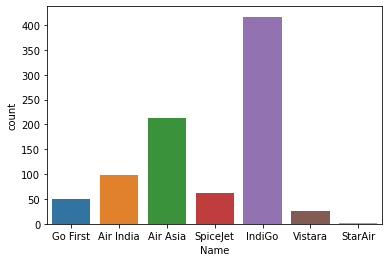

In [10]:
sns.countplot(df["Name"])

In [11]:
df['Source'].value_counts()

Pune         180
New Delhi    178
Hyderabad    110
Mumbai       100
Kolkata      100
Bangalore     80
Patna         60
Chennai       60
Name: Source, dtype: int64

In [12]:
df['Destination'].value_counts()

New Delhi     160
Kolkata       110
Bangalore     110
Lucknow        80
Goa            60
Mumbai         48
Chennai        40
Hyderabad      40
Guwahati       40
Dehradun       30
Pune           30
Jaipur         20
Patna          20
Tirupati       10
Coimbatore     10
Varanasi       10
Port Blair     10
Bagdogra       10
Kochi          10
Chandigarh     10
Ahmedabad      10
Name: Destination, dtype: int64

In [14]:
pd.crosstab(df['Source'],df['Destination'])


Destination,Ahmedabad,Bagdogra,Bangalore,Chandigarh,Chennai,Coimbatore,Dehradun,Goa,Guwahati,Hyderabad,...,Kochi,Kolkata,Lucknow,Mumbai,New Delhi,Patna,Port Blair,Pune,Tirupati,Varanasi
Source,,,,,,,,,,,,,,,,,,,,,
Bangalore,0,0,0,0,0,0,0,10,10,10,...,0,10,10,10,10,0,0,0,0,0
Chennai,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,60,0,0,0,0,0
Hyderabad,10,0,10,0,10,0,20,10,0,0,...,0,10,10,10,10,0,0,0,10,0
Kolkata,0,10,10,0,10,0,0,10,10,10,...,0,0,0,10,10,0,10,10,0,0
Mumbai,0,0,10,10,0,10,10,10,0,0,...,10,10,0,0,10,0,0,0,0,10
New Delhi,0,0,20,0,20,0,0,20,20,20,...,0,20,0,18,0,20,0,20,0,0
Patna,0,0,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pune,0,0,0,0,0,0,0,0,0,0,...,0,60,60,0,60,0,0,0,0,0


In [15]:
#row of the entire dataset where the price is maximum
df.loc[df['Price'].idxmax()]

Unnamed: 0            477
Name             SpiceJet
Date               23 May
Departure           12:10
Arrival             14:25
Source            Kolkata
Destination    Port Blair
Stops            Non Stop
Duration           2h 15m
Price               11228
Name: 477, dtype: object

In [16]:
#row of the entire dataset where the price is miniimum
df.loc[df['Price'].idxmin()]

Unnamed: 0           378
Name            Go First
Date               8 Mar
Departure          16:00
Arrival            17:10
Source         Hyderabad
Destination      Chennai
Stops           Non Stop
Duration          1h 10m
Price               1543
Name: 378, dtype: object

In [17]:
#stats of airlines with total stops
pd.crosstab(df['Name'],df['Stops'])

Stops,1 Stop,2 Stop(s),3 Stop(s),Non Stop
Name,,,,
Air Asia,148,19,0,46
Air India,44,5,1,49
Go First,13,0,0,36
IndiGo,252,0,0,165
SpiceJet,16,0,0,46
StarAir,0,0,0,2
Vistara,0,0,0,26


# Bivariate Analysis

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Go First'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Air Asia'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'IndiGo'),
  Text(5, 0, 'Vistara'),
  Text(6, 0, 'StarAir')])

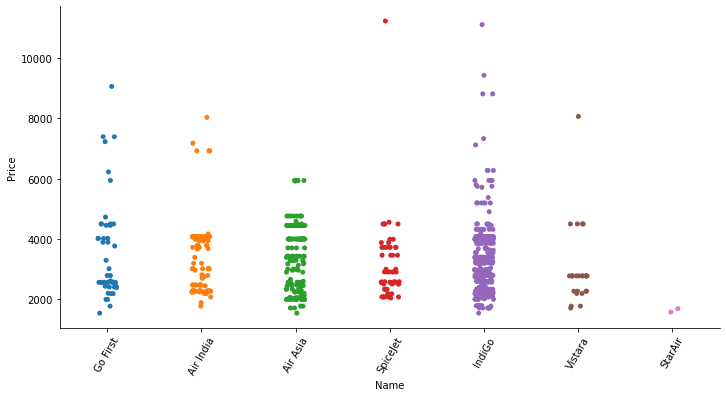

In [18]:
sns.catplot(x="Name", y="Price", data=df, aspect=2)
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'New Delhi'),
  Text(1, 0, 'Mumbai'),
  Text(2, 0, 'Bangalore'),
  Text(3, 0, 'Hyderabad'),
  Text(4, 0, 'Kolkata'),
  Text(5, 0, 'Pune'),
  Text(6, 0, 'Chennai'),
  Text(7, 0, 'Patna')])

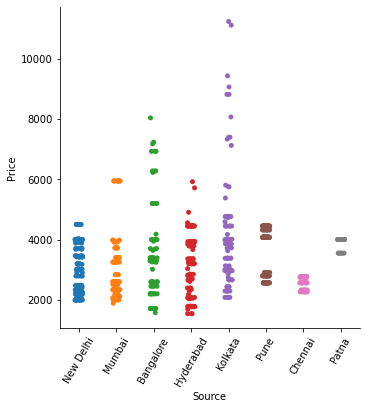

In [19]:
sns.catplot(x="Source", y="Price", data=df, aspect=1)
plt.xticks(rotation=60)

Flights from Kolkata and Bangalore have higher price

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Non Stop'),
  Text(1, 0, '1 Stop'),
  Text(2, 0, '2 Stop(s)'),
  Text(3, 0, '3 Stop(s)')])

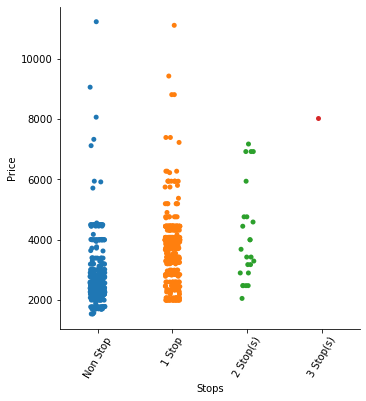

In [20]:
sns.catplot(x="Stops", y="Price", data=df)
plt.xticks(rotation=60)

Flights taking longer route i.e. with more number of stops have higher price.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, '19 May'),
  Text(1, 0, '13 Mar'),
  Text(2, 0, '8 Mar'),
  Text(3, 0, '10 Mar'),
  Text(4, 0, '9 Mar'),
  Text(5, 0, '23 Mar'),
  Text(6, 0, '12 Mar'),
  Text(7, 0, '26 Mar'),
  Text(8, 0, '27 Mar'),
  Text(9, 0, '5 Apr'),
  Text(10, 0, '4 May'),
  Text(11, 0, '28 Mar'),
  Text(12, 0, '7 Mar'),
  Text(13, 0, '1 Apr'),
  Text(14, 0, '22 Mar'),
  Text(15, 0, '20 Mar'),
  Text(16, 0, '17 Mar'),
  Text(17, 0, '18 Mar'),
  Text(18, 0, '19 Mar'),
  Text(19, 0, '29 Mar'),
  Text(20, 0, '7 Apr'),
  Text(21, 0, '31 Mar'),
  Text(22, 0, '23 May'),
  Text(23, 0, '2 Apr'),
  Text(24, 0, '25 Mar'),
  Text(25, 0, '4 Apr')])

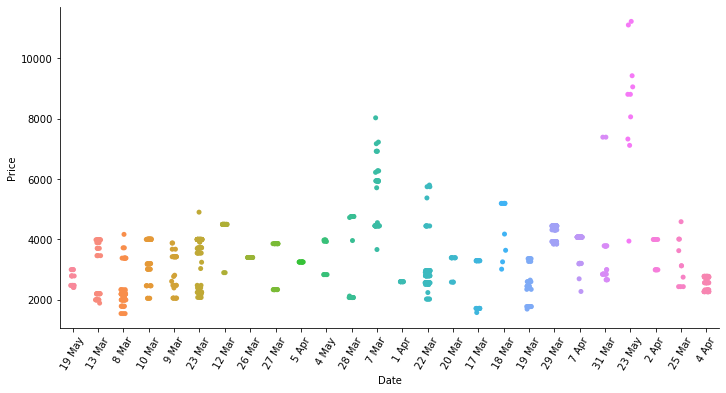

In [21]:
sns.catplot(x="Date", y="Price", data=df, aspect=2)
plt.xticks(rotation=60)

We observe that flights of May month is high as compared to next coming months.

In [22]:
df['Price'].groupby(df['Source']).mean()

Source
Bangalore    3508.150000
Chennai      2532.800000
Hyderabad    3144.690909
Kolkata      4122.570000
Mumbai       3113.620000
New Delhi    3033.269663
Patna        3955.600000
Pune         3730.233333
Name: Price, dtype: float64

Flights from Kolkata have highest price

In [23]:
df['Price'].groupby(df['Name']).mean()

Name
Air Asia     3489.281690
Air India    3397.616162
Go First     3545.979592
IndiGo       3411.681055
SpiceJet     3120.241935
StarAir      1634.500000
Vistara      3004.846154
Name: Price, dtype: float64

Go First and Air Asia flights are expensive.

# Data Cleaning

In [24]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [25]:
time= df[["Departure","Arrival","Duration","Date"]]
time=pd.DataFrame(time)
time.head()

,Departure,Arrival,Duration,Date
0,02:40,04:55,2h 15m,19 May
1,07:00,09:05,2h 05m,19 May
2,13:00,15:10,2h 10m,19 May
3,09:00,11:15,2h 15m,19 May
4,17:50,21:35,3h 45m,19 May


In [26]:
list=[]
hrs=[]
min=[]
list=time["Departure"]
for i in range(len(list)):
    str=[]
    str=list[i].split(':')
    hrs.append(str[0])  ## Seperating hours and minutes
    min.append(str[1])
time["Dep_time_hours"]=hrs
time["Dep_time_min"]=min

In [27]:
list=[]
hrs=[]
min=[]
list=time["Duration"]
for i in range(len(list)):
    str=[]
    str=list[i].split(' ')
    if(len(str)>1):
        hrs.append(str[0][:-1])   ## Seperating hours and minutes
        min.append(str[1][:-1])
    else:
        hrs.append(list[i][:-1])
        min.append('0')
time["Duration_hours"]=hrs
time["Duration_min"]=min

In [28]:
list=[]
hrs=[]
min=[]
list=time["Arrival"]
for i in range(len(list)):
    str=[]
    str=list[i].split(':')
    hrs.append(str[0])  ## Seperating hours and minutes
    min.append(str[1][:3])
time["Arrival_time_hours"]=hrs
time["Arrival_time_min"]=min

In [29]:
time.head()

,Departure,Arrival,Duration,Date,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min
0,02:40,04:55,2h 15m,19 May,02,40,2,15,04,55
1,07:00,09:05,2h 05m,19 May,07,00,2,05,09,05
2,13:00,15:10,2h 10m,19 May,13,00,2,10,15,10
3,09:00,11:15,2h 15m,19 May,09,00,2,15,11,15
4,17:50,21:35,3h 45m,19 May,17,50,3,45,21,35


In [30]:
list=[]
d=[]
m=[]
list=time["Date"]
for i in range(len(list)):
    d.append(list[i][:2])  ## Seperating date and month
    m.append(list[i][3:])
time["day"]=d
time["month"]=m

In [31]:
month=[]
for i in time["month"]:
    if i=="Jan":
        month.append(1)
    elif i=="Feb":
        month.append(2)
    elif i=="Mar":
        month.append(3)
    elif i=="Apr":
        month.append(4)
    elif i=="May":
        month.append(5)
    elif i=="Jun":
        month.append(6)
    elif i=="Jul":
        month.append(7)
    elif i=="Aug":
        month.append(8)
    elif i=="Sep":
        month.append(9)
    elif i=="Oct":
        month.append(10)
    elif i=="Nov":
        month.append(11)
    elif i=="Dec":
        month.append(12)
    else:
        month.append(np.nan)
time["month"]=month

In [32]:
time

,Departure,Arrival,Duration,Date,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month
0,02:40,04:55,2h 15m,19 May,02,40,2,15,04,55,19,5.0
1,07:00,09:05,2h 05m,19 May,07,00,2,05,09,05,19,5.0
2,13:00,15:10,2h 10m,19 May,13,00,2,10,15,10,19,5.0
3,09:00,11:15,2h 15m,19 May,09,00,2,15,11,15,19,5.0
4,17:50,21:35,3h 45m,19 May,17,50,3,45,21,35,19,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
863,04:50,14:35,9h 45m,7 Apr,04,50,9,45,14,35,7,NaN
864,00:45,10:35,9h 50m,7 Apr,00,45,9,50,10,35,7,NaN
865,07:40,19:40,12h 00m,7 Apr,07,40,12,00,19,40,7,NaN
866,18:50,13:25 + 1 day,18h 35m,7 Apr,18,50,18,35,13,25,7,NaN


In [33]:
time.drop(columns=["Departure","Arrival","Duration","Date","month"],inplace=True)

In [34]:
data=pd.concat([df,time],axis=1) # joining both dataframes
data.head()

,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day
0,Go First,19 May,02:40,04:55,New Delhi,Mumbai,Non Stop,2h 15m,2410,02,40,2,15,04,55,19
1,Air India,19 May,07:00,09:05,New Delhi,Mumbai,Non Stop,2h 05m,2476,07,00,2,05,09,05,19
2,Air India,19 May,13:00,15:10,New Delhi,Mumbai,Non Stop,2h 10m,2476,13,00,2,10,15,10,19
3,Air India,19 May,09:00,11:15,New Delhi,Mumbai,Non Stop,2h 15m,2476,09,00,2,15,11,15,19
4,Air India,19 May,17:50,21:35,New Delhi,Mumbai,1 Stop,3h 45m,2476,17,50,3,45,21,35,19


In [35]:
df["Stops"].value_counts()

1 Stop       473
Non Stop     370
2 Stop(s)     24
3 Stop(s)      1
Name: Stops, dtype: int64

In [36]:
data["Stops"]=data["Stops"].replace({'Non Stop':0,'1 Stop':1,'2 Stop(s)':2,'3 Stop(s)':3,'4 Stop(s)':4})
data.head()

,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day
0,Go First,19 May,02:40,04:55,New Delhi,Mumbai,0,2h 15m,2410,02,40,2,15,04,55,19
1,Air India,19 May,07:00,09:05,New Delhi,Mumbai,0,2h 05m,2476,07,00,2,05,09,05,19
2,Air India,19 May,13:00,15:10,New Delhi,Mumbai,0,2h 10m,2476,13,00,2,10,15,10,19
3,Air India,19 May,09:00,11:15,New Delhi,Mumbai,0,2h 15m,2476,09,00,2,15,11,15,19
4,Air India,19 May,17:50,21:35,New Delhi,Mumbai,1,3h 45m,2476,17,50,3,45,21,35,19


In [37]:
data.drop(columns=["Departure","Arrival","Duration",],inplace=True)

In [51]:
data.drop(columns=["Date"],inplace=True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 867
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Name                868 non-null    int32
 1   Source              868 non-null    int32
 2   Destination         868 non-null    int32
 3   Stops               868 non-null    int64
 4   Price               868 non-null    int32
 5   Dep_time_hours      868 non-null    int32
 6   Dep_time_min        868 non-null    int32
 7   Duration_hours      868 non-null    int32
 8   Duration_min        868 non-null    int32
 9   Arrival_time_hours  868 non-null    int32
 10  Arrival_time_min    868 non-null    int32
 11  day                 868 non-null    int32
 12  Total_duration      868 non-null    int32
dtypes: int32(12), int64(1)
memory usage: 86.5 KB


In [53]:
df_type_dict={'Dep_time_hours':int,'Dep_time_min':int,'Duration_hours':int,'Duration_min':int,
              'Arrival_time_hours':int,'Arrival_time_min':int,'day':int}
data=data.astype(df_type_dict)
data.dtypes

Name                  int32
Source                int32
Destination           int32
Stops                 int64
Price                 int32
Dep_time_hours        int32
Dep_time_min          int32
Duration_hours        int32
Duration_min          int32
Arrival_time_hours    int32
Arrival_time_min      int32
day                   int32
Total_duration        int32
dtype: object

In [54]:
time.head()

,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day
0,02,40,2,15,04,55,19
1,07,00,2,05,09,05,19
2,13,00,2,10,15,10,19
3,09,00,2,15,11,15,19
4,17,50,3,45,21,35,19


In [55]:
#introducing a new column total duration
data["Total_duration"]=data["Duration_hours"]*60+data["Duration_min"]

In [56]:
data.head()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,Total_duration
0,2,5,14,0,2410,2,40,2,15,4,55,19,135
1,1,5,14,0,2476,7,0,2,5,9,5,19,125
2,1,5,14,0,2476,13,0,2,10,15,10,19,130
3,1,5,14,0,2476,9,0,2,15,11,15,19,135
4,1,5,14,1,2476,17,50,3,45,21,35,19,225


In [57]:
data.shape

(868, 13)

In [58]:
lab_enc=LabelEncoder()
cols=["Name", "Source", "Destination"]
for i in cols:
    df1= lab_enc.fit_transform(data[i])
    data[i]=df1
data.head()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,Total_duration
0,2,5,14,0,2410,2,40,2,15,4,55,19,135
1,1,5,14,0,2476,7,0,2,5,9,5,19,125
2,1,5,14,0,2476,13,0,2,10,15,10,19,130
3,1,5,14,0,2476,9,0,2,15,11,15,19,135
4,1,5,14,1,2476,17,50,3,45,21,35,19,225


# Check for correlation

In [59]:
data.corr()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,Total_duration
Name,1.000000,-0.152759,-0.022303,-0.303189,-0.076160,-0.140767,-0.047529,-0.261970,0.143009,-0.051394,0.033196,-0.049013,-0.251365
Source,-0.152759,1.000000,-0.010208,0.158601,0.123767,-0.138317,0.143724,0.177228,-0.076218,-0.014969,-0.060607,0.192371,0.171383
Destination,-0.022303,-0.010208,1.000000,-0.218197,-0.034382,0.118643,-0.033267,-0.116171,-0.030812,-0.040284,0.061993,-0.111000,-0.117570
Stops,-0.303189,0.158601,-0.218197,1.000000,0.428779,-0.171213,0.040897,0.760794,0.071376,0.088119,-0.043785,0.051459,0.761515
Price,-0.076160,0.123767,-0.034382,0.428779,1.000000,-0.103151,0.052601,0.429082,0.098913,-0.022702,-0.077839,0.142976,0.433287
Dep_time_hours,-0.140767,-0.138317,0.118643,-0.171213,-0.103151,1.000000,-0.020803,-0.061303,-0.086519,0.184178,-0.136265,-0.049492,-0.066591
Dep_time_min,-0.047529,0.143724,-0.033267,0.040897,0.052601,-0.020803,1.000000,0.045136,-0.019288,-0.028185,-0.048589,0.088922,0.043656
Duration_hours,-0.261970,0.177228,-0.116171,0.760794,0.429082,-0.061303,0.045136,1.000000,0.046845,0.068989,-0.032288,0.005318,0.997906
Duration_min,0.143009,-0.076218,-0.030812,0.071376,0.098913,-0.086519,-0.019288,0.046845,1.000000,0.039963,0.085802,-0.178913,0.111364
Arrival_time_hours,-0.051394,-0.014969,-0.040284,0.088119,-0.022702,0.184178,-0.028185,0.068989,0.039963,1.000000,0.007271,-0.082100,0.071223


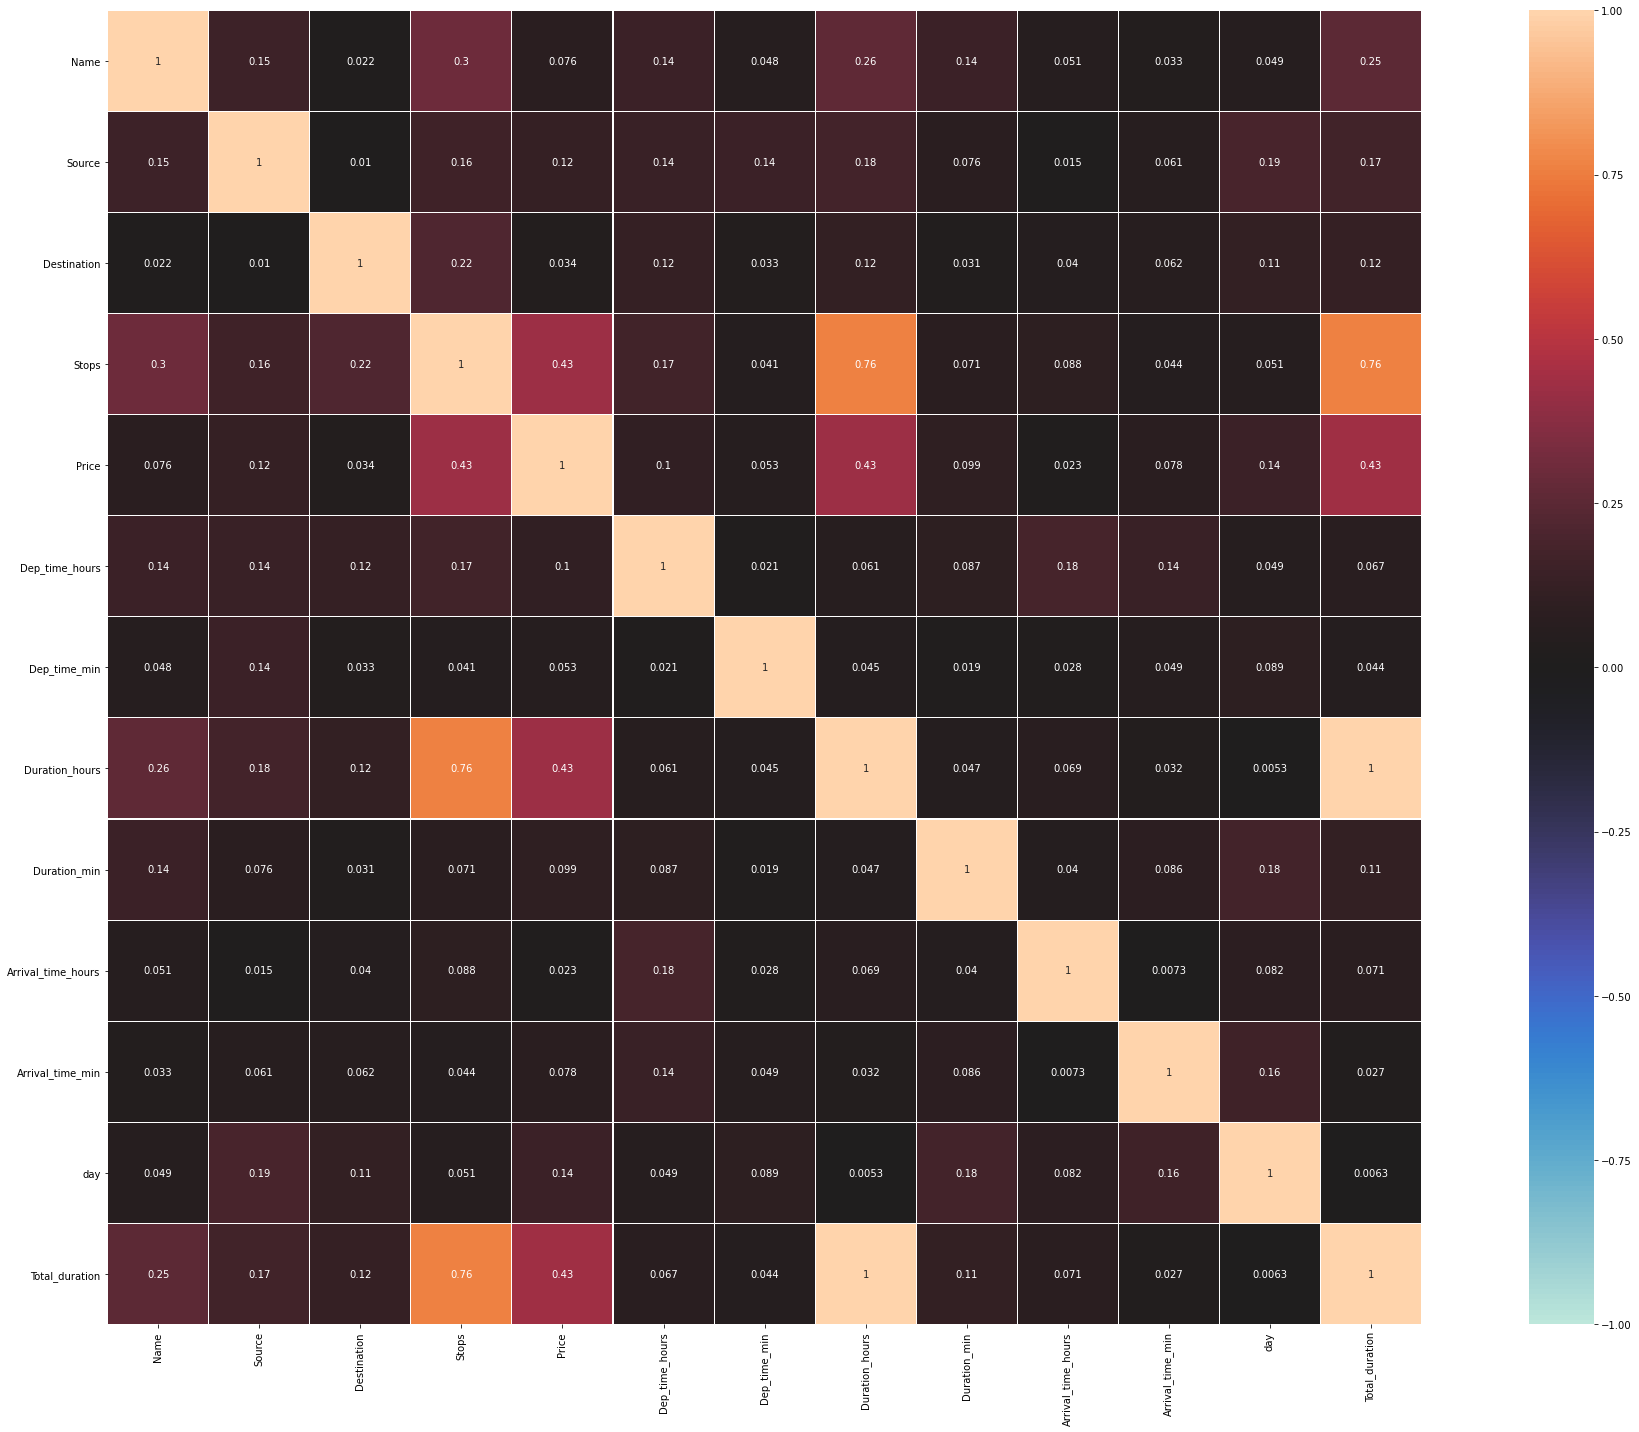

In [60]:
## HeatMap
df_corr= data.corr().abs()
plt.figure(figsize=(30,20))
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, square=True, center=0, fmt='.2g', linewidth=.1)
plt.tight_layout()

In [61]:
# Correlation with target variable
corr_mat=data.corr()
corr_mat["Price"].sort_values(ascending=False)

Price                 1.000000
Total_duration        0.433287
Duration_hours        0.429082
Stops                 0.428779
day                   0.142976
Source                0.123767
Duration_min          0.098913
Dep_time_min          0.052601
Arrival_time_hours   -0.022702
Destination          -0.034382
Name                 -0.076160
Arrival_time_min     -0.077839
Dep_time_hours       -0.103151
Name: Price, dtype: float64

# Check for outliers

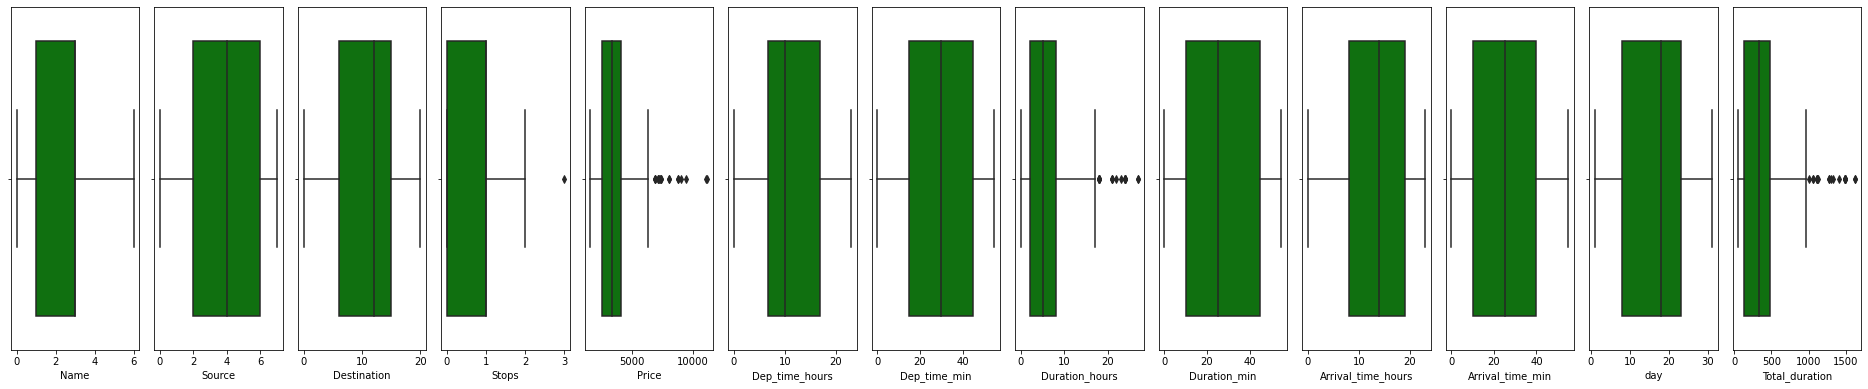

In [62]:
collist=data.columns.values
plt.figure(figsize=(40,80))
for i in range(0,len(collist)):
    plt.subplot(15,20,i+1)
    sns.boxplot(data[collist[i]],color='green',orient='v')
    plt.tight_layout()

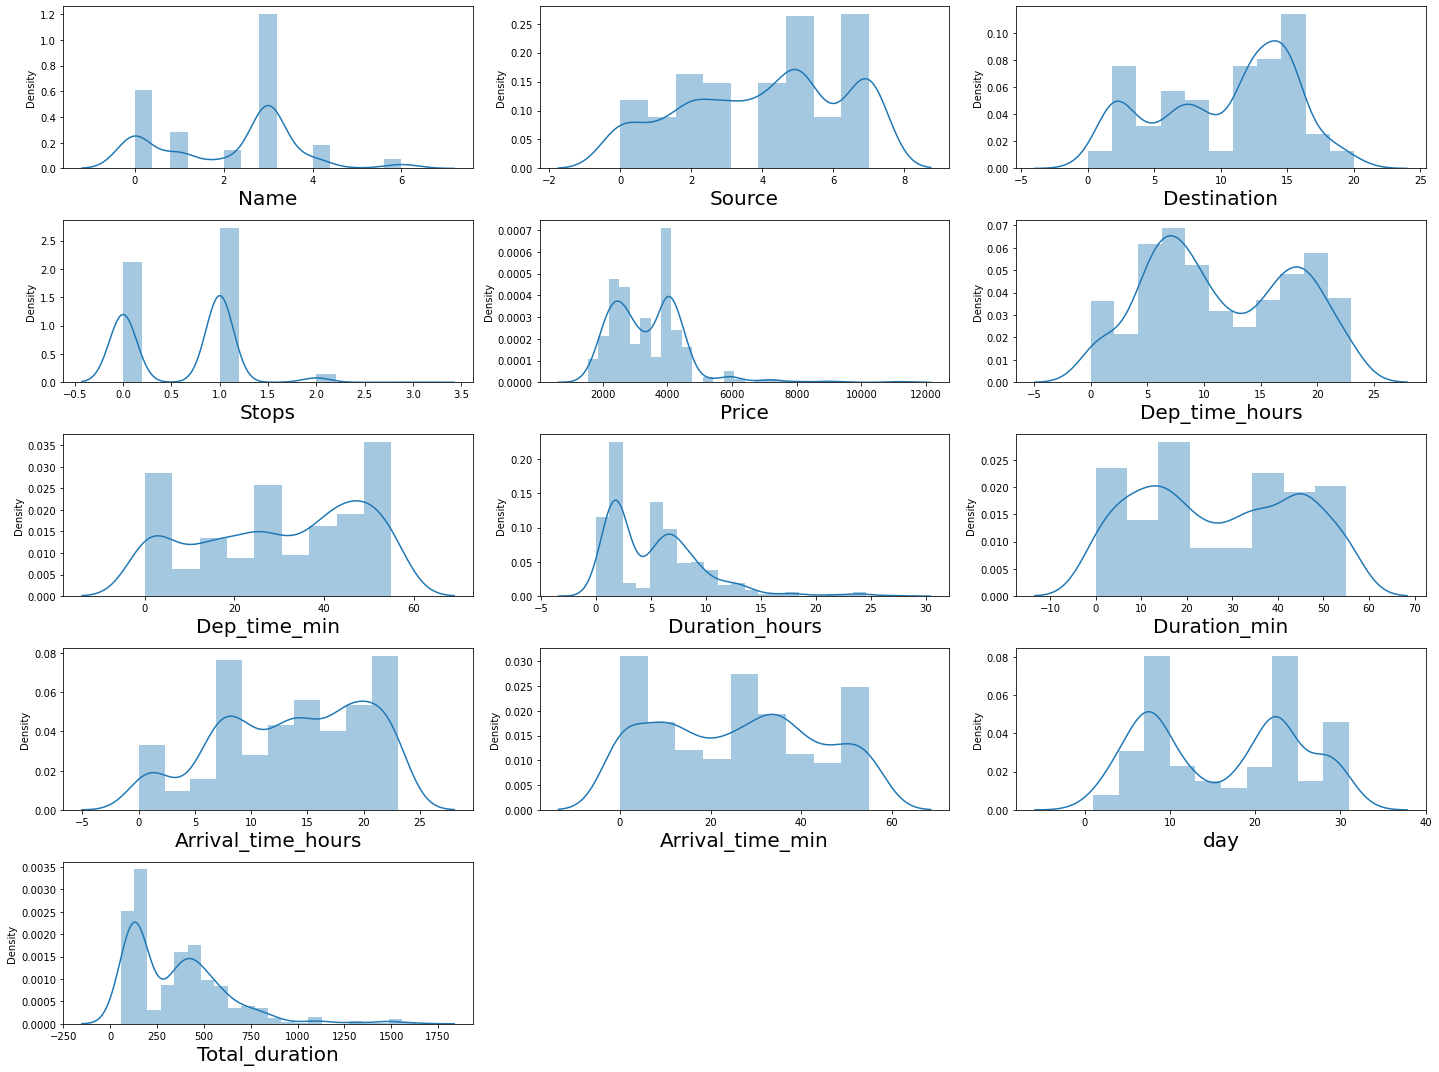

In [63]:
## checking for Normal Distribution of curve
plt.figure(figsize=(20,15),facecolor='white')
plotnumber=1

for column in data:
    if plotnumber<=15:
        ax=plt.subplot(5,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()

# Data Pre-Processing

In [64]:
data.drop(columns=["Duration_hours","Duration_min"],inplace=True)

In [65]:
data.skew()

Name                 -0.019153
Source               -0.250532
Destination          -0.360744
Stops                 0.189218
Price                 1.669104
Dep_time_hours        0.092735
Dep_time_min         -0.264833
Arrival_time_hours   -0.324131
Arrival_time_min      0.069559
day                   0.026559
Total_duration        1.526506
dtype: float64

In [66]:
from scipy import stats
z=np.abs(stats.zscore(data))
index=(np.where(z>3)[0])
df_new=data.drop(data.index[index])
df_new.shape

(842, 11)

In [67]:
print("Percentage of data loss = ",((868-842)/868)*100)

Percentage of data loss =  2.995391705069124


In [68]:
df_new.skew()

Name                 -0.030760
Source               -0.262401
Destination          -0.359816
Stops                 0.107831
Price                 0.407058
Dep_time_hours        0.092021
Dep_time_min         -0.255953
Arrival_time_hours   -0.321268
Arrival_time_min      0.076647
day                   0.030675
Total_duration        0.834844
dtype: float64

In [69]:
df_new["Total_duration"]=np.log(df_new["Total_duration"])
print(df_new.skew().loc["Total_duration"])

-0.16046916966657676


In [70]:
# Seperating feature and target variable
x=df_new.drop(columns=["Price"])
y=df_new["Price"]

In [71]:
## Scaling data
scale= StandardScaler()
x_scaled=scale.fit_transform(x)

# Model Building

In [72]:
#Finding the best random state and r2_score
for i in range(100):
    x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=.20,random_state=i)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print('At random state',i,',the model performs well')
        print('Training r2_score is: ',r2_score(y_train,pred_train)*100)
        print('Testing r2_score is: ',r2_score(y_test,pred_test)*100)

In [73]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=.20,random_state=81)

In [74]:
#Initializing the instance of the model
lm= LinearRegression()
knn= KNeighborsRegressor()
dt= DecisionTreeRegressor()
rmf= RandomForestRegressor()
gb= GradientBoostingRegressor()

models=[]
models.append(('LinearRegression',lr))
models.append(('KNeighborsRegressor',knn))
models.append(('DecisionTreeRegressor',dt))
models.append(('RandomForestRegressor',rmf))
models.append(('GradientBoostingRegressor',gb))

In [75]:
Model=[]
r2score=[]
mse=[]
cvs=[]
for name,model in models:
    print("****",name,"****")
    Model.append(name)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    print('\n')
    AS=model.score(x_test,y_test)
    print('accuracy_score: ',AS)
    r2score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x_train,y_train,cv=5).mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    mse.append(mean_squared_error(y_test,y_pred))
    print('mean_squared_error ',mean_squared_error(y_test,y_pred))
    print('\n\n')

**** LinearRegression ****


accuracy_score:  0.2314733659763678


cross_val_score:  0.3302510512164042


mean_squared_error  745741.3825329223



**** KNeighborsRegressor ****


accuracy_score:  0.4844526500696187


cross_val_score:  0.4322802320147142


mean_squared_error  500262.41964497045



**** DecisionTreeRegressor ****


accuracy_score:  0.8365784637361364


cross_val_score:  0.7183261702926887


mean_squared_error  158576.4201183432



**** RandomForestRegressor ****


accuracy_score:  0.8806685491147601


cross_val_score:  0.8607226265370864


mean_squared_error  115793.51609053258



**** GradientBoostingRegressor ****


accuracy_score:  0.8230828623379685


cross_val_score:  0.7904567859562321


mean_squared_error  171671.90438554637





In [76]:
df=pd.DataFrame({'Model':Model, 'Accuracy_score': r2score,'Cross_val_score':cvs,'Mean_Squared_Error':mse})
df

,Model,Accuracy_score,Cross_val_score,Mean_Squared_Error
0,LinearRegression,23.147337,33.025105,745741.382533
1,KNeighborsRegressor,48.445265,43.228023,500262.419645
2,DecisionTreeRegressor,83.657846,71.832617,158576.420118
3,RandomForestRegressor,88.066855,86.072263,115793.516091
4,GradientBoostingRegressor,82.308286,79.045679,171671.904386


By looking at various metrics, Random Forest Regressor is considered to be the best model. We will now use GridSearchCV to tune model for better results.

# Hyper-Parametric Tuning

In [77]:
rmf= RandomForestRegressor()
params={'max_features':['auto','sqrt'],'n_estimators':[50,80], 'criterion':['mse','mae'],
       'max_depth':[5,10], 'min_samples_split':[4,6],
       'min_samples_leaf':[2,3]}
grd=GridSearchCV(rmf,param_grid=params)
grd.fit(x_train,y_train)
print('best params=>',grd.best_params_)

best params=> {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80}


In [79]:
rmf= RandomForestRegressor(criterion= 'mse', max_depth= 10, max_features= 'auto', min_samples_leaf= 2, 
                           min_samples_split= 4, n_estimators= 80)
rmf.fit(x_train,y_train)
y_pred=rmf.predict(x_test)
print("Random Forest Regression: Accuracy = ",rmf.score(x_test,y_test))
print("\n Mean Squared Error= ",mean_squared_error(y_test,y_pred))
print("\n Root Mean Squared Error= ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("\n Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))

Random Forest Regression: Accuracy =  0.8697525647018703

 Mean Squared Error=  126385.86376904644

 Root Mean Squared Error=  355.5078955087305

 Mean Absolute Error=  214.09028697201683


OUR FINAL MODEL GIVES AN ACCURACY OF 86.97%

In [80]:
#Comparing actual and predicted values with the help of a dataframe
predictions=pd.DataFrame({'Original_price':y_test, 'Predicted_price':y_pred})
predictions

,Original_price,Predicted_price
492,3381,3425.181960
213,2000,2081.528370
755,4001,3979.120372
866,4077,4069.829291
609,4077,4076.429291
...,...,...
537,2966,3294.097594
179,3402,3251.891818
531,2966,3551.788765
573,2798,2806.364150


In [82]:
## saving model
filename= "flight_Price_prediction.pickle"
pickle.dump(rmf, open(filename, 'wb'))